<a href="https://colab.research.google.com/github/shay-dan/DS_workshop_OpenUIL/blob/main/Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#5.Augmentation

We have finished our EDA. Now we create our new train/val/test split.

We will perform augmentations, hopefully to fix some of our findings from the EDA.

We use the following augmentations: 'horizontal_flip', 'rescale', 'translate', 'rotate', 'shear', 'resize' and 'hsv',to add "noise" to our data - i.e. to try and prevent the data from learning irrelevent features:

For example, we try to fix 'top' vs 'side' classification by rotating or shearing, number of object in image by translating (may cause some object to be removed from the image), size of object as a primary feature by resizing or rescaling, colors (mainly a problem with plate color) by using "HSV", and in general to fix our class imbalance.

First we'll set aside our test set as it is not to be augmented. We will use 5 **pairs** of each class randomly sampled, to get a test set of 100 pairs - 1 side image, 1 top image for each pair.

We need pairs for our volume calculations (without pairs we can only get area)

In [ ]:
# we check if the are any images with no pair
def get_no_pair(path):
  side = []
  top = []
  no_pair = []
  for file in os.listdir(path):
    tmp = file.split(".")[0]
    split = tmp.split("(")[0]
    if split[-1] == 'S':
      side.append(file)
    if split[-1] == 'T':
      top.append(file)

  for file in side:
    tmp = file.split(".")[0]
    split_l = tmp.split("S")[0]
    split_r = file.split("S")[1]
    if (split_l + 'T' + split_r) not in top:
      no_pair.append(file)

  for file in top:
    tmp = file.split(".")[0]
    split_l = tmp.split("T")[0]
    split_r = file.split("T")[1]
    if (split_l + 'S' + split_r) not in side:
      no_pair.append(file)

  return no_pair

In [ ]:
def make_test_set(path_to_json, path, no_pair_JPG):

  with open(path_to_json, 'r') as f:
    annotations = json.load(f)

  test_list = []

  test = {'plum': [],
        'mix': [],
        'lemon': [],
        'banana': [],
        'pear': [],
        'orange': [],
        'apple': [],
        'peach': [],
        'mango': [],
        'bun': [],
        'doughnut': [],
        'egg': [],
        'litchi': [],
        'bread': [],
        'fired_dough_twist': [],
        'mooncake': [],
        'tomato': [],
        'qiwi': [],
        'sachima': [],
        'grape': []}

  test_set = {'plum': [],
        'mix': [],
        'lemon': [],
        'banana': [],
        'pear': [],
        'orange': [],
        'apple': [],
        'peach': [],
        'mango': [],
        'bun': [],
        'doughnut': [],
        'egg': [],
        'litchi': [],
        'bread': [],
        'fired_dough_twist': [],
        'mooncake': [],
        'tomato': [],
        'qiwi': [],
        'sachima': [],
        'grape': []}

  for cls in test:
    for img in annotations['images']:
      if img["file_name"].split("0")[0] == cls:
          test[cls].append(img['folder'] + img['file_name'])

  for cls in test:
    while len(test_set[cls]) < 5:
      tmp = random.sample(test[cls], len(test[cls]))
      for i in range(len(tmp)):
        if len(test_set[cls]) == 5:
          break
        temp = tmp[i]
        split = temp.split("/JPEGImages/")[1]
        split = split.split("(")[0]
        if temp.split("/JPEGImages/")[1] in no_pair_JPG:
          continue
        else:
          if split[-1] == "S":
            test_set[cls].append(temp)
          else:
            continue

    for cls in test_set:
      for file in test_set[cls]:
        if len(test_set[cls]) >= 10:
          break
        tmp = file.replace("S(","T(")
        test_set[cls].append(tmp)

    for cls in test_set:
      for i in range(len(test_set[cls])):
        test_list.append(test_set[cls][i])

  return test_list

In [ ]:
def make_trainval_set(path_to_json,test_list,path, no_pair):
  with open(path_to_json, 'r') as f:
    annotations = json.load(f)

  test = []
  trainval = []
  for img in annotations['images']:
    if (img['folder'] + img['file_name']) in test_list and (img['file_name']) not in no_pair:
      test.append((img['folder'] + img['file_name']))
    else:
      trainval.append(img['folder'] + img['file_name'])

  return test, trainval

In [ ]:
def get_split(path_to_json, path):

  no_pair = get_no_pair(path)
  test_list = make_test_set(path_to_json,path, no_pair)
  test, trainval = make_trainval_set(path_to_json,test_list,path, no_pair)

  while len(test) < 200:
    test_list = make_test_set(path_to_json,path, no_pair)
    test, trainval = make_trainval_set(path_to_json,test_list,path, no_pair)

  return test, trainval

In [ ]:
test, trainval = get_split("/content/Ecustfd-COCO-no-seg-masks-cleaned/JPEGImages/AllClean.json",'/content/ECUSTFD-resized-/JPEGImages')

Now we will use "splitfolders" to make our split, given our predefined test set

In [ ]:
!pip install split-folders
import splitfolders

In [ ]:
def make_split(trainval, test):

  root = '/content/tmp/'
  path_to_anns = "/content/Ecustfd-COCO-no-seg-masks-cleaned/JPEGImages/"

  if not os.path.exists(root):
    os.mkdir(root)

  if not os.path.exists(root + 'trainval'):
    os.mkdir(root + 'trainval')

  for i in trainval:
    shutil.copy(i, root + 'trainval')

  splitfolders.ratio('/content/tmp/', output="/content/Temp/",
                    seed=42, ratio=(.85, .15),
                    group_prefix=None) # default values

  root = '/content/Ecustfd-COCO-no-seg-masks-cleaned-split/'
  ins_array = ['train','val','test']

  if not os.path.exists(root):
    os.mkdir(root)

  for i in ins_array:
    if not os.path.exists(root + i):
      os.mkdir(root + i)

  for file in test:
    shutil.copy(path_to_anns + (file.split("/JPEGImages/")[1]).split(".")[0] + ".xml", '/content/Ecustfd-COCO-no-seg-masks-cleaned-split/test')

  for file in os.listdir("/content/Temp/train/trainval"):
    shutil.copy(path_to_anns + file.split(".")[0] + ".xml", '/content/Ecustfd-COCO-no-seg-masks-cleaned-split/train')

  for file in os.listdir("/content/Temp/val/trainval"):
    shutil.copy(path_to_anns + file.split(".")[0] + ".xml", '/content/Ecustfd-COCO-no-seg-masks-cleaned-split/val')

  shutil.rmtree("/content/tmp", ignore_errors=True)
  shutil.rmtree("/content/Temp", ignore_errors=True)

  dataset_train = importer.ImportVOC(path='/content/Ecustfd-COCO-no-seg-masks-cleaned-split/train', path_to_images='/content/Ecustfd-COCO-no-seg-masks-cleaned/JPEGImages', name="Train")
  dataset_val = importer.ImportVOC(path='/content/Ecustfd-COCO-no-seg-masks-cleaned-split/val', path_to_images='/content/Ecustfd-COCO-no-seg-masks-cleaned/JPEGImages', name="Val")
  dataset_test = importer.ImportVOC(path='/content/Ecustfd-COCO-no-seg-masks-cleaned-split/test', path_to_images='/content/Ecustfd-COCO-no-seg-masks-cleaned/JPEGImages', name="Test")
  dataset_train.export.ExportToCoco()
  dataset_val.export.ExportToCoco()
  dataset_test.export.ExportToCoco()
  dataset_train.export.ExportToYoloV5()
  dataset_val.export.ExportToYoloV5()
  dataset_test.export.ExportToYoloV5()

In [ ]:
make_split(trainval, test)

Copying files: 2725 files [00:04, 678.19 files/s]
Exporting to COCO file...: 100%|██████████| 410/410 [00:00<00:00, 2503.40it/s]


In [ ]:
root = '/content/split/'

if not os.path.exists(root):
  os.mkdir(root)

if not os.path.exists(root + 'train/'):
  os.mkdir(root + 'train/')

if not os.path.exists(root + 'val/'):
  os.mkdir(root + 'val/')

if not os.path.exists(root + 'test/'):
  os.mkdir(root + 'test/')

train_l = []
for file in os.listdir("/content/Ecustfd-COCO-no-seg-masks-cleaned-split/train/"):
  train_l.append(file)
for file in os.listdir("/content/ECUSTFD-resized-/JPEGImages/"):
  if file.split(".")[0] + ".xml" in train_l:
    shutil.copyfile("/content/ECUSTFD-resized-/JPEGImages/" + file, "/content/split/train/" + file)
shutil.copyfile("/content/Ecustfd-COCO-no-seg-masks-cleaned-split/train/Train.json", "/content/split/train/Train.json")

val_l = []
for file in os.listdir("/content/Ecustfd-COCO-no-seg-masks-cleaned-split/val/"):
  val_l.append(file)
for file in os.listdir("/content/ECUSTFD-resized-/JPEGImages/"):
  if file.split(".")[0] + ".xml" in val_l:
    shutil.copyfile("/content/ECUSTFD-resized-/JPEGImages/" + file, "/content/split/val/" + file)
shutil.copyfile("/content/Ecustfd-COCO-no-seg-masks-cleaned-split/val/Val.json", "/content/split/val/Val.json")

test_l = []
for file in os.listdir("/content/Ecustfd-COCO-no-seg-masks-cleaned-split/test/"):
  test_l.append(file)
for file in os.listdir("/content/ECUSTFD-resized-/JPEGImages/"):
  if file.split(".")[0] + ".xml" in test_l:
    shutil.copyfile("/content/ECUSTFD-resized-/JPEGImages/" + file, "/content/split/test/" + file)
shutil.copyfile("/content/Ecustfd-COCO-no-seg-masks-cleaned-split/test/Test.json", "/content/split/test/Test.json")

'/content/split/test/Test.json'

Now we will apply augmentations to our train and val sets, to solve the class imbalances.

In [ ]:
!git clone https://github.com/Paperspace/DataAugmentationForObjectDetection.git
%cd DataAugmentationForObjectDetection
from data_aug.data_aug import * #this has to stay here
from data_aug.bbox_util import * #this has to stay here
%cd /content

Cloning into 'DataAugmentationForObjectDetection'...
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 141 (delta 10), reused 8 (delta 8), pack-reused 122
Receiving objects: 100% (141/141), 10.19 MiB | 7.28 MiB/s, done.
Resolving deltas: 100% (22/22), done.
/content/DataAugmentationForObjectDetection
/content


In [ ]:
train = []
for file in os.listdir("/content/Ecustfd-COCO-no-seg-masks-cleaned-split/train"):
  if file == "/content/Ecustfd-COCO-no-seg-masks-cleaned-split/train/Train.json":
    continue
  else:
    train.append(file.split(".")[0] + ".JPG")

val = []
for file in os.listdir("/content/Ecustfd-COCO-no-seg-masks-cleaned-split/val"):
  if file == "/content/Ecustfd-COCO-no-seg-masks-cleaned-split/val/Val.json":
    continue
  else:
    val.append(file.split(".")[0] + ".JPG")

In [ ]:
train_ = train.copy()
train_classes_dict = {'plum': 0,
      'mix': 0,
      'lemon': 0,
      'banana': 0,
      'pear': 0,
      'orange': 0,
      'apple': 0,
      'peach': 0,
      'mango': 0,
      'bun': 0,
      'doughnut': 0,
      'egg': 0,
      'litchi': 0,
      'bread': 0,
      'fired_dough_twist': 0,
      'mooncake': 0,
      'tomato': 0,
      'qiwi': 0,
      'sachima': 0,
      'grape': 0}
for cls in train_classes_dict:
  for i in train_:
    if i.split("0")[0] == cls:
      train_classes_dict[cls] += 1

In [ ]:
val_ = val.copy()
val_classes_dict = {'plum': 0,
      'mix': 0,
      'lemon': 0,
      'banana': 0,
      'pear': 0,
      'orange': 0,
      'apple': 0,
      'peach': 0,
      'mango': 0,
      'bun': 0,
      'doughnut': 0,
      'egg': 0,
      'litchi': 0,
      'bread': 0,
      'fired_dough_twist': 0,
      'mooncake': 0,
      'tomato': 0,
      'qiwi': 0,
      'sachima': 0,
      'grape': 0}
for cls in val_classes_dict:
  for i in val_:
    if i.split("0")[0] == cls:
      val_classes_dict[cls] += 1

In [ ]:
# gets bbox cords in coco format (x_top_left,y_top_left, width, height) from json file

def get_bbox_coco(path_to_img,path_to_json,split):
  with open(path_to_json) as f:
    data = json.load(f)
  # print(path_to_img)
  for item in data["images"]:
    if (item["file_name"] == path_to_img.split(split + "/")[1]):
      idx = item["id"]

  bbox_coco = []
  for item in data["annotations"]:
    if item['image_id'] == idx:
      bbox_coco.append(item['bbox'])
  bbox_coco = np.array(bbox_coco)

  return bbox_coco

# gets bbox cords in coco format and returns bbox in VOC foramt (x_top_left,y_top_left, x_bottom_right, y_bottom_right)
def bbox_coco_to_voc(bbox_coco):
  new_bbox = np.zeros((bbox_coco.shape[0],4))
  length = new_bbox.shape[0]
  for i in range(length):
    x_min = bbox_coco[i][0]
    y_min = bbox_coco[i][1]
    x_max = x_min + bbox_coco[i][2]
    y_max = y_min + bbox_coco[i][3]
    new_bbox[i] = np.array([x_min, y_min,x_max, y_max])

  return new_bbox

def voc_to_coco(voc_bbox):
  new_bbox = np.zeros((voc_bbox.shape[0],4))
  length = new_bbox.shape[0]
  for i in range(length):
    x_min = voc_bbox[i][0]
    y_min = voc_bbox[i][1]
    x_max = voc_bbox[i][2] - x_min
    y_max = voc_bbox[i][3] - y_min
    new_bbox[i] = np.array([x_min, y_min,x_max, y_max])

  return new_bbox

Now we must update our json file to be consistent with our augmentations, we must make sure that there aren't any missing values or mismatches.

In [ ]:
def update_json(path_to_img,path_to_json,img,new_name,bboxes,aug,split,len,len_anns):

  with open(path_to_json) as f:
    data = json.load(f)

  out_file = open(path_to_json, "w")
  # updates "images" by appending the augmented to the json
  for item in data["images"]:
    if (item["file_name"] == path_to_img.split(split + "/")[1]):
      idx = item["id"]
      if aug == 'resize':
        data["images"].append({
          "id": item["id"] + len,
          "folder":  item["folder"],
          "file_name":  new_name,
          "path":  item["path"],
          "width": img.shape[0],
          "height": img.shape[1],
          "depth": item["depth"],
        })
      else:
        data["images"].append({
          "id": item["id"] + len,
          "folder":  item["folder"],
          "file_name":  new_name,
          "path":  item["path"],
          "width": item["width"],
          "height": item["height"],
          "depth": item["depth"],
        })

  changed_bbox_coco = []
  j = 0
  flag  = 0
  # updates "annotations" by appending the augmented to the json
  for item in data["annotations"]:
    tmp_bboxes = bboxes.copy()
    stop = tmp_bboxes.shape[0]
    tmp_bboxes = tmp_bboxes.tolist()

    if item['image_id'] == idx:
      flag += 1
      if flag > stop: # to check if we lost an annotation, we want to prevent skipping the item["id"]
        # print(flag, stop)
        # print(new_name, item["id"] + len_anns - 1)
        len_anns -= 1
        break
      # after some augmentations (translate), we could lose an annotation
      if j == stop:
        break
      data["annotations"].append({
        "image_id": item['image_id'] + len,
        "id": item['id'] + len_anns,
        "segmented": item['segmented'],
        "bbox": tmp_bboxes[j],
        "area": item['area'],
        "segmentation": item['segmentation'],
        "iscrowd": item['iscrowd'],
        "pose": item['pose'],
        "truncated": item['truncated'],
        "category_id": item['category_id'],
        "difficult": item['difficult']
      })
      changed_bbox_coco.append(item['bbox'])
      j += 1

  changed_bbox_coco = np.array(changed_bbox_coco)

  json.dump(data, out_file, indent = 4)
  out_file.close()

  return len_anns

def augmentations(path_to_img, path_to_json, aug,split,len,len_anns):

  aug_arr = ['horizontal_flip','rescale', 'translate', 'rotate','shear','resize','hsv']
  img = cv2.imread(path_to_img)[:,:,::-1]   #opencv loads images in bgr. the [:,:,::-1] does bgr -> rgb/
  img = img.copy()
  new_name = aug + "_" + path_to_img.split(split + "/")[1]
  bbox_coco = get_bbox_coco(path_to_img,path_to_json,split)
  bboxes = bbox_coco_to_voc(bbox_coco)
  if aug == aug_arr[0]:
    img_, bboxes_ = RandomHorizontalFlip(1)(img.copy(), bboxes.copy())
  elif aug == aug_arr[1]:
    img_, bboxes_ = RandomScale(0.3, diff = True)(img.copy(), bboxes.copy())
  elif aug == aug_arr[2]:
    img_, bboxes_ = RandomTranslate(0.3, diff = True)(img.copy(), bboxes.copy())
  elif aug == aug_arr[3]:
    img_, bboxes_ = RandomRotate(20)(img.copy(), bboxes.copy())
  elif aug == aug_arr[4]:
    img_, bboxes_ = RandomShear(0.2)(img.copy(), bboxes.copy())
  elif aug == aug_arr[5]:
    img_, bboxes_ = Resize(200)(img.copy(), bboxes.copy())
  elif aug == aug_arr[6]:
    img_, bboxes_ = RandomHSV(100, 100, 100)(img.copy(), bboxes.copy())

  with open(path_to_json) as f:
    data = json.load(f)
  for file in data["images"]:
    if file["file_name"] == new_name:
      new_name = "_" + new_name

  # updates "images" by appending the augmented to the json
  cv2.imwrite(os.path.join("/content/split/", split.lower(), new_name), img_[:,:,::-1])
  coco_bboxes = voc_to_coco(bboxes_)
  len_anns = update_json(path_to_img, path_to_json,img_,new_name,coco_bboxes,aug,split,len,len_anns)
  return len_anns

def make_augmentations(path_to_json,path_to_img, split_list, split_dict,split):
  count = 0
  len = 0
  len_anns = 0
  if split == "val":
    while len < 1100: # 20 cls * 55 img per cls
      with open(path_to_json, 'r') as f:
        tmp = json.load(f)
      for i,item in enumerate(tmp["images"]):
        len = i
      len += 1
      for i,item in enumerate(tmp["annotations"]):
        len_anns = i
      len_anns += 1
      if len == 1100:
        break
      for file_name in split_list:
        aug_arr = ['horizontal_flip','rescale', 'translate', 'rotate','shear','resize','hsv']
        cls = file_name.split("0")[0]
        if cls in split_dict:
          if split_dict[cls] < 55:
            aug = random.choice(aug_arr)
            if count%100 == 0:
              print("count is: ", count)
            len_anns = augmentations(path_to_img + file_name,path_to_json,aug, split,len,len_anns)
            count += 1
            split_dict[cls] += 1
            if split_dict[cls] == 55:
              break
          else:
            if cls != 'mix':
              len -= 1
              len_anns -= 2
            else:
              len -= 1
              len_anns -= 3
            continue
  else:
    while len < 5000: # 20 cls * 250 img per cls
      with open(path_to_json, 'r') as f:
        tmp = json.load(f)
      for i,item in enumerate(tmp["images"]):
        len = i
      len += 1
      for i,item in enumerate(tmp["annotations"]):
        len_anns = i
      len_anns += 1
      if len == 5000:
        break
      for file_name in split_list:
        aug_arr = ['horizontal_flip','rescale', 'translate', 'rotate','shear','resize','hsv']
        cls = file_name.split("0")[0]
        if cls in split_dict:
          if split_dict[cls] < 250:
            aug = random.choice(aug_arr)
            if count%100 == 0:
              print("count is: ", count)
            len_anns = augmentations(path_to_img + file_name,path_to_json,aug, split,len,len_anns)
            count += 1
            split_dict[cls] += 1
            if split_dict[cls] == 250:
              break
          else:
            if cls != 'mix':
              len -= 1
              len_anns -= 2
            else:
              len -= 1
              len_anns -= 3
            continue

We decided to use a split of train/val/test = 5000/1100/200

In [ ]:
def display_images_with_coco_annotations(image_paths, annotations, split, colors=None):
    fig, axs = plt.subplots(4, 5, figsize=(10, 10))

    for ax, img_path in zip(axs.ravel(), image_paths):
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        tmp = (img_path.split("/" + split + "/")[1]).split("0")[0]

        ax.set_title(tmp, fontsize=10)
        ax.imshow(image)
        ax.axis('off')

        if colors is None:
            colors = plt.cm.get_cmap('tab10')

        img_filename = os.path.basename(img_path)
        img_id = next(item for item in annotations['images'] if item["file_name"] == img_filename)['id']
        img_annotations = [ann for ann in annotations['annotations'] if ann['image_id'] == img_id]

        for ann in img_annotations:
            category_id = ann['category_id']
            color = colors(category_id % 10)
            bbox = ann['bbox']
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor=color, facecolor='none')
            ax.add_patch(rect)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    plt.show()

In [ ]:
path_to_img = "/content/split/train/"
shutil.copyfile("/content/Ecustfd-COCO-no-seg-masks-cleaned-split/train/Train.json", "/content/updated_Train.json")
path_to_json = "/content/updated_Train.json"
split = "train"
split_list = train_
split_dict = train_classes_dict
make_augmentations(path_to_json,path_to_img, split_list, split_dict,split)

count is:  0
count is:  100
count is:  200
count is:  300
count is:  400
count is:  500
count is:  600
count is:  700
count is:  800
count is:  900
count is:  1000
count is:  1100
count is:  1200
count is:  1300
count is:  1400
count is:  1500
count is:  1600
count is:  1700
count is:  1800
count is:  1900
count is:  2000
count is:  2100
count is:  2200
count is:  2300
count is:  2400
count is:  2500
count is:  2600


let's look at some of our augmentations

In [ ]:
with open('/content/updated_Train.json', 'r') as f:
    annotations = json.load(f)

# Get all image files
image_dir = "/content/split/train/"
all_image_files = [os.path.join(image_dir, img['file_name']) for img in annotations['images']]
for i in range(2400):
  if i%20 == 0 and i >= 2300:
    print(i)
    batch = all_image_files[i:i+20]
    display_images_with_coco_annotations(batch, annotations,"train")

In [ ]:
path_to_img = "/content/split/val/"
shutil.copyfile("/content/Ecustfd-COCO-no-seg-masks-cleaned-split/val/Val.json", "/content/updated_Val.json")
path_to_json = "/content/updated_Val.json"
split = "val"
split_list = val_
split_dict = val_classes_dict
make_augmentations(path_to_json,path_to_img, split_list, split_dict,split)

count is:  0
count is:  100
count is:  200
count is:  300
count is:  400
count is:  500
count is:  600


In [ ]:
with open('/content/updated_Val.json', 'r') as f:
    annotations = json.load(f)

# Get all image files
image_dir = "/content/split/val/"
all_image_files = [os.path.join(image_dir, img['file_name']) for img in annotations['images']]
for i in range(500):
  if i%20 == 0 and i >= 400:
    print(i)
    batch = all_image_files[i:i+20]
    display_images_with_coco_annotations(batch, annotations,"val")

Now let's see how the sets are balanced

In [ ]:
with open('/content/updated_Train.json','r') as f:
    data = json.loads(f.read())
df_tr_ims = pd.json_normalize(data, record_path =['images'])
df_tr_anns = pd.json_normalize(data, record_path =['annotations'])
df_tr_cat = pd.json_normalize(data, record_path =['categories'])

In [ ]:
df_tr_ims = df_tr_ims.drop(columns=['folder'])
df_tr_ims = df_tr_ims.drop(columns=['path'])
df_tr_ims.rename(columns = {'depth':'channels'}, inplace = True)
df_tr_ims.rename(columns = {'id':'image_id'}, inplace = True)
df_tr_anns = df_tr_anns.drop(columns=['segmented'])
df_tr_anns = df_tr_anns.drop(columns=['segmentation'])
df_tr_anns = df_tr_anns.drop(columns=['pose'])
df_tr_anns = df_tr_anns.drop(columns=['truncated'])
df_tr_anns = df_tr_anns.drop(columns=['difficult'])
df_tr_anns = df_tr_anns.drop(columns=['iscrowd'])
df_tr_anns = df_tr_anns.drop(columns=['area'])
df = df_tr_ims.merge(df_tr_anns, how="outer", on="image_id")
for i in range(len(df["file_name"])):
  category_id = df["category_id"][i]
  for id in df_tr_cat['id']:
    if category_id == id:
      df.at[i, 'category_id'] = df_tr_cat["name"][id]
df.rename(columns = {'category_id':'class'}, inplace = True)
df = df.drop(columns = "image_id")
df = df.drop(columns = "id")
columns_titles = ["file_name", "width", "height", "channels", "class","bbox"]
df_train=df.reindex(columns=columns_titles)
df_train["class"].value_counts()

coin                 4943
lemon                 328
tomato                327
apple                 319
banana                314
qiwi                  312
orange                307
pear                  299
mango                 294
doughnut              250
sachima               250
peach                 250
egg                   250
litchi                250
bun                   250
mooncake              250
bread                 250
fired_dough_twist     250
plum                  250
grape                 250
Name: class, dtype: int64

In [ ]:
df_train

,file_name,width,height,channels,class,bbox
0,doughnut003T(3).JPG,816,612,3,doughnut,"[227.0, 278.0, 269.0, 274.0]"
1,doughnut003T(3).JPG,816,612,3,coin,"[562.0, 97.0, 64.0, 70.0]"
2,plum004T(3).JPG,816,612,3,plum,"[445.0, 302.0, 171.0, 151.0]"
3,plum004T(3).JPG,816,612,3,coin,"[188.0, 136.0, 67.0, 64.0]"
4,orange009T(3).JPG,816,612,3,orange,"[443.0, 249.0, 226.0, 206.0]"
...,...,...,...,...,...,...
10188,_resize_grape001T(5).JPG,200,200,3,coin,"[29.166666666666664, 47.05882352941177, 14.215..."
10189,_horizontal_flip_grape002S(17).JPG,816,612,3,grape,"[118.0, 178.0, 320.0, 173.0]"
10190,_horizontal_flip_grape002S(17).JPG,816,612,3,coin,"[638.0, 305.0, 68.0, 64.0]"
10191,_hsv_grape002S(14).JPG,816,612,3,grape,"[376.0, 227.0, 307.0, 167.0]"


In [ ]:
no_coin_train_df = df_train.copy()
for i in range(len(no_coin_train_df)):
  if no_coin_train_df['class'][i] == "coin":
    no_coin_train_df = no_coin_train_df.drop(i)
no_coin_train_df = no_coin_train_df.reset_index(drop=True)
no_coin_train_df

,file_name,width,height,channels,class,bbox
0,doughnut003T(3).JPG,816,612,3,doughnut,"[227.0, 278.0, 269.0, 274.0]"
1,plum004T(3).JPG,816,612,3,plum,"[445.0, 302.0, 171.0, 151.0]"
2,orange009T(3).JPG,816,612,3,orange,"[443.0, 249.0, 226.0, 206.0]"
3,mango009S(10).JPG,816,612,3,mango,"[483.0, 348.0, 179.0, 141.0]"
4,lemon004S(7).JPG,816,612,3,lemon,"[476.0, 172.0, 145.0, 122.0]"
...,...,...,...,...,...,...
5245,_rotate_grape002S(16).JPG,816,612,3,grape,"[382.13013581404, 198.68395786490584, 262.0599..."
5246,_hsv_grape001S(12).JPG,816,612,3,grape,"[329.0, 151.0, 448.0, 254.0]"
5247,_resize_grape001T(5).JPG,200,200,3,grape,"[64.2156862745098, 25.980392156862745, 103.921..."
5248,_horizontal_flip_grape002S(17).JPG,816,612,3,grape,"[118.0, 178.0, 320.0, 173.0]"


<ipython-input-111-63688bb7c385>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=[label for label in labels.index], y=labels.values, palette=np.array(pal[::-1])[rank])
<ipython-input-111-63688bb7c385>:6: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  ax = sns.barplot(x=[label for label in labels.index], y=labels.values, palette=np.array(pal[::-1])[rank])
<ipython-input-111-63688bb7c385>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90);


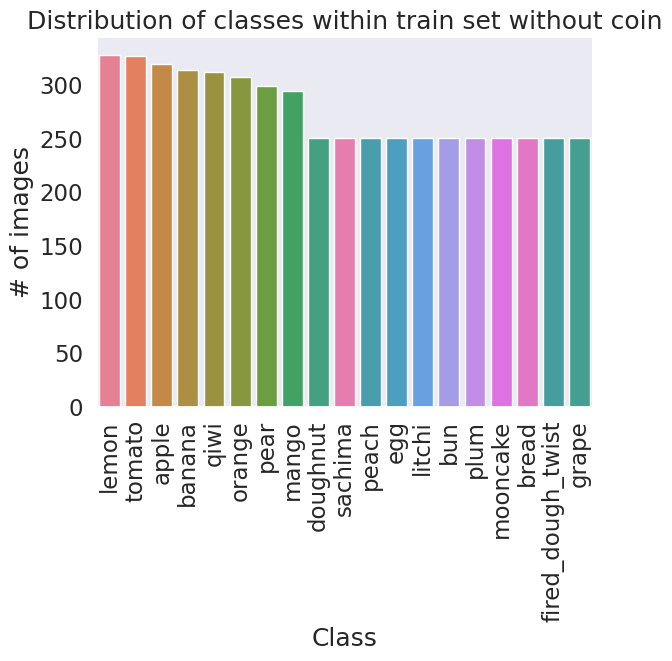

In [ ]:
labels = no_coin_train_df["class"].value_counts()

pal = sns.color_palette("husl", len(labels))
rank = labels.argsort().argsort()

ax = sns.barplot(x=[label for label in labels.index], y=labels.values, palette=np.array(pal[::-1])[rank])
plt.title("Distribution of classes within train set without coin")
plt.ylabel("# of images")
plt.xlabel("Class")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

In [ ]:
with open('/content/updated_Val.json','r') as f:
    data = json.loads(f.read())
df_vl_ims = pd.json_normalize(data, record_path =['images'])
df_vl_anns = pd.json_normalize(data, record_path =['annotations'])
df_vl_cat = pd.json_normalize(data, record_path =['categories'])

In [ ]:
df_vl_ims = df_vl_ims.drop(columns=['folder'])
df_vl_ims = df_vl_ims.drop(columns=['path'])
df_vl_ims.rename(columns = {'depth':'channels'}, inplace = True)
df_vl_ims.rename(columns = {'id':'image_id'}, inplace = True)
df_vl_anns = df_vl_anns.drop(columns=['segmented'])
df_vl_anns = df_vl_anns.drop(columns=['segmentation'])
df_vl_anns = df_vl_anns.drop(columns=['pose'])
df_vl_anns = df_vl_anns.drop(columns=['truncated'])
df_vl_anns = df_vl_anns.drop(columns=['difficult'])
df_vl_anns = df_vl_anns.drop(columns=['iscrowd'])
df_vl_anns = df_vl_anns.drop(columns=['area'])
df = df_vl_ims.merge(df_vl_anns, how="outer", on="image_id")
for i in range(len(df["file_name"])):
  category_id = df["category_id"][i]
  for id in df_vl_cat['id']:
    if category_id == id:
      df.at[i, 'category_id'] = df_vl_cat["name"][id]
df.rename(columns = {'category_id':'class'}, inplace = True)
df = df.drop(columns = "image_id")
df = df.drop(columns = "id")
columns_titles = ["file_name", "width", "height", "channels", "class","bbox"]
df_val=df.reindex(columns=columns_titles)
df_val["class"].value_counts()

coin                 1085
tomato                 84
mango                  80
orange                 75
banana                 73
pear                   65
lemon                  60
qiwi                   57
apple                  56
bun                    55
plum                   55
grape                  55
fired_dough_twist      55
doughnut               55
sachima                55
litchi                 55
bread                  55
peach                  55
mooncake               55
egg                    55
Name: class, dtype: int64

In [ ]:
df_val

,file_name,width,height,channels,class,bbox
0,tomato004S(20).JPG,816,612,3,tomato,"[456.0, 144.0, 205.0, 138.0]"
1,tomato004S(20).JPG,816,612,3,coin,"[149.0, 229.0, 73.0, 68.0]"
2,mango001S(4).JPG,816,612,3,mango,"[403.0, 259.0, 258.0, 157.0]"
3,mango001S(4).JPG,816,612,3,coin,"[119.0, 363.0, 64.0, 66.0]"
4,plum002S(2).JPG,816,612,3,plum,"[453.0, 312.0, 154.0, 136.0]"
...,...,...,...,...,...,...
2235,_resize_egg007S(1).JPG,200,200,3,coin,"[30.88235294117647, 109.06862745098039, 16.421..."
2236,_rescale_egg002S(8).JPG,816,612,3,egg,"[455.7136672534588, 240.79098218020445, 176.47..."
2237,_rescale_egg002S(8).JPG,816,612,3,coin,"[31.274467360531485, 319.0777054506157, 88.238..."
2238,_translate_egg003S(1).JPG,816,612,3,egg,"[722.0, 160.0, 94.0, 105.0]"


In [ ]:
no_coin_val_df = df_val.copy()
for i in range(len(no_coin_val_df)):
  if no_coin_val_df['class'][i] == "coin":
    no_coin_val_df = no_coin_val_df.drop(i)
no_coin_val_df = no_coin_val_df.reset_index(drop=True)
no_coin_val_df

,file_name,width,height,channels,class,bbox
0,tomato004S(20).JPG,816,612,3,tomato,"[456.0, 144.0, 205.0, 138.0]"
1,mango001S(4).JPG,816,612,3,mango,"[403.0, 259.0, 258.0, 157.0]"
2,plum002S(2).JPG,816,612,3,plum,"[453.0, 312.0, 154.0, 136.0]"
3,mix011T(1).JPG,816,612,3,orange,"[372.0, 40.0, 223.0, 222.0]"
4,mix011T(1).JPG,816,612,3,tomato,"[383.0, 307.0, 199.0, 198.0]"
...,...,...,...,...,...,...
1150,resize_bun008T(3).JPG,200,200,3,bun,"[88.23529411764706, 86.51960784313725, 64.2156..."
1151,___translate_litchi002S(4).JPG,816,612,3,litchi,"[267.0, 419.0, 122.0, 104.0]"
1152,_resize_egg007S(1).JPG,200,200,3,egg,"[123.2843137254902, 90.9313725490196, 33.08823..."
1153,_rescale_egg002S(8).JPG,816,612,3,egg,"[455.7136672534588, 240.79098218020445, 176.47..."


<ipython-input-116-5ce344fb4607>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=[label for label in labels.index], y=labels.values, palette=np.array(pal[::-1])[rank])
<ipython-input-116-5ce344fb4607>:6: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  ax = sns.barplot(x=[label for label in labels.index], y=labels.values, palette=np.array(pal[::-1])[rank])
<ipython-input-116-5ce344fb4607>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90);


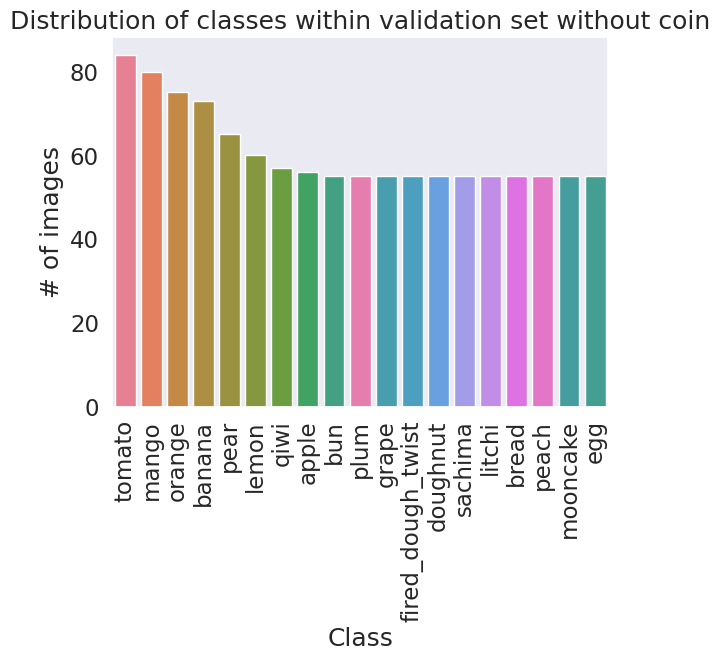

In [ ]:
labels = no_coin_val_df["class"].value_counts()

pal = sns.color_palette("husl", len(labels))
rank = labels.argsort().argsort()

ax = sns.barplot(x=[label for label in labels.index], y=labels.values, palette=np.array(pal[::-1])[rank])
plt.title("Distribution of classes within validation set without coin")
plt.ylabel("# of images")
plt.xlabel("Class")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

## Summary
The Augmentation is done. we used different types of augmentations, horizontal flips, rescaling, translating, rotating, shearing, resizing and color augmentation, and saved our augmented images and annotations to disk to be consistent later. We fixed our class imbalance, and now each class in the train set has at least 250 images, in the validations set at least 55, and all classes are pretty much balance.

Now we can move forward to the prediction stage.